New EnbPI Bootstrap Steps:
1) Extract and Clean Data
2) Preprocess Data
3) Bootstrap Synthetic Data
4) Train Bootstrap Models
5) LOO Predict and Mean Aggregate
6) Get Conformal Prediction Interval 
7) Get Coverage Rate on Test
8) Output Results

#### **STEP 1) Extract and Clean Data**
  - Read following data:
    - Solar Atlanta Data
    - Solar Cali Cities Data
    - Appliances Data
    - Green House Data
    - Beijing Air Data
  - Perform preliminary cleaning:
    - Remove temporal and other unncessary columns
    - Shift target column 1-step ahead (this is one-step forecasting)
    - Remove last row 

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from typing import Optional

from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [2]:
def read_data(data_name, max_data_size):
    data_dir = "Data/"

    if data_name.lower() == "solar":
        """
        4 (Alternative). NREL Solar data at Atlanta Downtown in 2018.
            - 24 observations per day and separately equally by 1H @ half an hour mark everytime
        Data descriptions see Solar Writeup
        Data download:
        (With API) https://nsrdb.nrel.gov/data-sets/api-instructions.html
        (Manual) https://maps.nrel.gov/nsrdb-viewer
        Properties:
            - Type: multivariate (5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly (at every 30-min mark)
        """
        file_name = data_dir + "Solar_Atl_data.csv"
        data_df = pd.read_csv(file_name, skiprows=2)
        # data_df.shape  # 8760, 14
        data_df.drop(columns=data_df.columns[0:5], inplace=True)  # remove 5 temporal columns
        data_df.drop(columns="Unnamed: 13", inplace=True)
        # data_df.shape  # 8760, 8
        target_column = "DHI"

    elif data_name.title() in _get_cali_cities():  # "Palo_Alto"
        """
        Properties:
            - Type: multivariate (1 datetime index, 5 temporal columns, 7 feature columns, 1 target)
            - Length: 8760
            - Period: entire 2018
            - Frequency: hourly
        """
        file_name = data_dir + f"{data_name.title()}_data.csv"
        data_df = pd.read_csv(file_name)
        data_df.drop(columns=data_df.columns[0:6], inplace=True)  # remove datetime index and 5 temporal columns
        target_column = "DHI"

    elif data_name.lower() == "appliances":
        """
        2. Appliances energy prediction Data Set
        The data set is at 10 min for about 4.5 months.
        The column named 'Appliances' is the response. Other columns are predictors
        https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
        Properties:
            - Type: multivariate (1 temporal column, 27 feature columns, 1 target)
            - Length: 19735
            - Period: 2016-01-11 @5PM to 2016-05-27 @6PM
            - Frequency: every 10-min
        """
        file_name = data_dir + "appliances_data.csv"
        data_df = pd.read_csv(file_name, delimiter=",")
        # data_df.shape  # (19736, 29)
        data_df.drop("date", inplace=True, axis=1)  # remove the temporal column
        data_df.loc[:, data_df.columns != "Appliances"]
        target_column = "Appliances"

    elif data_name.lower() == "green_house":
        """
        All datasets are Multivariate time-series. They have respective Github for more details as well.
        1. Greenhouse Gas Observing Network Data Set
        Time from 5.10-7.31, 2010, with 4 samples everyday, 6 hours apart between data poits.
        Goal is to "use inverse methods to determine the optimal values of the weights in the weighted sum of 15 tracers that best matches the synthetic observations"
        In other words, find weights so that first 15 tracers will be as close to the last as possible.
        Note, data at many other grid cells are available. Others are in Downloads/🌟AISTATS Data/Greenhouse Data
        https://archive.ics.uci.edu/ml/datasets/Greenhouse+Gas+Observing+Network
        Properties:
            - Type: multivariate (15 feature columns aka tracers(?), 1 target)
            - Length: 327
            - Period: 2010-05-10 to 2010-07-31
            - Frequency: every 6-hours
        """
        file_name = data_dir + "green_house_data.csv"
        data_df = pd.read_csv(file_name, header=None, sep=" ").T
        # data_df.shape  # 327, 16 Note, rows are 16 time series (first 15 from tracers, last from synthetic).
        target_column = 15

    elif data_name.lower() == "beijing_air":
        """
        3. Beijing Multi-Site Air-Quality Data Data Set
        This data set includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites.
        Time period from 3.1, 2013 to 2.28, 2017.
        PM2.5 or PM10 would be the response.
        https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data
        Properties:
            - Type: multivariate (1 index, 4 temporal columns, 12 feature columns, 1 target)
            - Length: 35064
            - Period: 2013-03-01 to 2017-02-28
            - Frequency: hourly
        """
        file_name = data_dir + "Beijing_air_Tiantan_data.csv"
        data_df = pd.read_csv(file_name)
        # data_df.shape  # 35064, 18
        data_df.drop(
            columns=["No", "year", "month", "day", "hour", "wd", "station"],
            inplace=True,
            axis=1,
        )
        data_df.dropna(inplace=True)
        # data_df.shape  # 32907, 11
        target_column = "PM2.5"

    # pick maximum of X data points (for speed)
    data_df = data_df.iloc[: min(max_data_size, data_df.shape[0]), :]
    # shift target column back by one (for single-step forecast)
    data_df[target_column] = data_df[target_column].shift(-1)
    # remove final row as it does not contain target column value anymore
    data_df = data_df.iloc[:-1 , :]
    
    return data_df, target_column


def _get_cali_cities():
    cali_cities = [
        "Fremont",
        "Milpitas",
        "Mountain_View",
        "North_San_Jose",
        "Palo_Alto",
        "Redwood_City",
        "San_Mateo",
        "Santa_Clara",
        "Sunnyvale",
    ]
    return cali_cities

In [3]:
data_name = "beijing_air"  # "palo_alto", "appliances", "green_house", "beijing_air" 
max_data_size = 10000

In [4]:
data_df, target_column = read_data(data_name, max_data_size)

In [5]:
data_df.shape, target_column

((9999, 11), 'PM2.5')

In [6]:
data_df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,6.0,6.0,4.0,8.0,300.0,81.0,-0.5,1024.5,-21.4,0.0,5.7
1,6.0,29.0,5.0,9.0,300.0,80.0,-0.7,1025.1,-22.1,0.0,3.9
2,6.0,6.0,4.0,12.0,300.0,75.0,-1.2,1025.3,-24.6,0.0,5.3
3,5.0,6.0,4.0,12.0,300.0,74.0,-1.4,1026.2,-25.5,0.0,4.9
4,10.0,5.0,7.0,15.0,400.0,70.0,-1.9,1027.1,-24.5,0.0,3.2


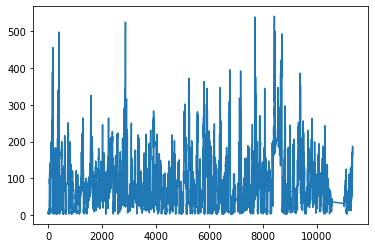

In [7]:
data_df[target_column].plot();

Double-check that there is no NaN values in the target column

In [8]:
data_df[target_column].isna().sum()

0

#### **Execute EnbPI Function**

Contains Steps 2-8)

In [9]:
# Helper functions

# Step 2) this is the AR-transformer. can replace with something from sktime.  ################
def one_dimen_transform(y_train, y_test, n_lags):
    n = len(y_train)
    n1 = len(y_test)
    X_train = np.zeros((n - n_lags, n_lags))  # from n_lags+1,...,n
    X_test = np.zeros((n1, n_lags))  # from n-n_lags,...,n+n1-n_lags
    for i in range(n - n_lags):
        X_train[i, :] = y_train[i : i + n_lags]
    for i in range(n1):
        if i < n_lags:
            X_test[i, :] = np.r_[y_train[n - n_lags + i :], y_test[:i]]
        else:
            X_test[i, :] = y_test[i - n_lags : i]
    y_train = y_train[n_lags:]
    return [X_train, X_test, y_train, y_test]


# Step 3) ################
def generate_bootstrap_samples(n, m, B, bootstrap_type, block_length, random_seed):
    samples_idx = np.zeros((B, m), dtype=int)

    for b in range(B):
        if bootstrap_type == "random":  # RB
            np.random.seed(b + random_seed)
            sample_idx = np.random.choice(a=n, size=m, replace=True)
        elif bootstrap_type == "nonoverlapping":  # NBB
            sample_idx = _id_nbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "moving":  # MBB
            sample_idx = _id_mbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "circular":  # CBB
            sample_idx = _id_cbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        elif bootstrap_type == "stationary":  # SBB
            sample_idx = _id_sbb_bootstrap(
                n_obs=n, block_length=block_length, random_seed=b + random_seed,
            )
        else:
            raise ValueError("boostrap_type not supported")      
        samples_idx[b, :] = sample_idx

    return samples_idx


# Non-overlapping block bootstrap (NBB)
def _id_nbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int] = 10
) -> np.ndarray:
    """Create bootstrapped indexes with the none overlapping block bootstrap
    ('nbb') strategy given the number of observations in a timeseries and
    the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    
    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    blocks = rng.permutation(x=np.arange(0, n_obs, block_length)).reshape(-1, 1)
    _id = (blocks + nexts).ravel()[:n_obs]

    return _id


# Moving block bootstrap (MBB)
def _id_mbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the moving block bootstrap
    ('mbb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    last_block = n_obs - block_length
    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = (blocks + nexts).ravel()[:n_obs]

    return _id


# Circular block bootstrap (MBB)
def _id_cbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the circular block bootstrap
    ('cbb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint

    n_blocks = int(np.ceil(n_obs / block_length))
    nexts = np.repeat([np.arange(0, block_length)], n_blocks, axis=0)
    
    last_block = n_obs
    blocks = rng_integers(low=0, high=last_block, size=(n_blocks, 1), dtype=int)
    _id = np.mod((blocks + nexts).ravel(), n_obs)[:n_obs]

    return _id


# Stationary block bootstrap (SBB)
def _id_sbb_bootstrap(
    n_obs: int, block_length: int, random_seed: Optional[int]=10
) -> np.ndarray:
    """Create bootstrapped indexes with the stationary block bootstrap
    ('sb') strategy given the number of observations in a timeseries
    and the length of the blocks.
    Returns
    -------
    _id : array
        Bootstrapped indexes.
    """
    rng = default_rng(random_seed)
    try:
        rng_integers = rng.integers
    except AttributeError:
        rng_integers = rng.randint
    #
    rng_poisson = rng.poisson
    #
    random_block_length = rng_poisson(lam=block_length, size=n_obs)
    random_block_length[random_block_length < 3] = 3
    random_block_length[random_block_length >= n_obs] = n_obs
    random_block_length = random_block_length[random_block_length.cumsum() <= n_obs]
    residual_block = n_obs - random_block_length.sum()
    if residual_block > 0:
        random_block_length = np.append(random_block_length, residual_block)
    #
    n_blocks = random_block_length.shape[0]
    nexts = np.zeros((n_blocks, random_block_length.max() + 1))
    nexts[np.arange(n_blocks), random_block_length] = 1
    nexts = np.flip(nexts, 1).cumsum(1).cumsum(1).ravel()
    nexts = (nexts[nexts > 1] - 2).astype(int)
    #
    last_block = n_obs - random_block_length.max()
    blocks = np.zeros(n_obs, dtype=int)
    if last_block > 0:
        blocks = rng_integers(low=0, high=last_block, size=n_blocks)
        blocks = np.repeat(blocks, random_block_length)
    _id = blocks + nexts
    #
    return _id


# Step 4) ################
def initiate_regressor(model_type):
    min_alpha = 0.0001
    max_alpha = 10

    if model_type == "lasso":
        model = LassoCV(alphas=np.linspace(min_alpha, max_alpha, 10))
    elif model_type == "ridge":
        model = RidgeCV(alphas=np.linspace(min_alpha, max_alpha, 10))
    elif model_type == "random_forest":
        model = RandomForestRegressor(
            n_estimators=10,
            criterion="squared_error",
            bootstrap=False,
            max_depth=2,
            n_jobs=-1,
        )
    elif model_type == "extra_trees":
        model = ExtraTreesRegressor(
            n_estimators=10,
            criterion="squared_error",
            bootstrap=False,
            max_depth=2,
            n_jobs=-1
        )
    else:
        raise ValueError("model_type not supported")

    return model

In [10]:
# Main executable function

def enbpi_exec(
    data_df,
    data_name,
    target_column,
    method,
    train_fractions,
    B_list,
    bootstrap_types,
    block_lengths,
    model_types,
    alphas,
    itrial=0,
    one_dim_list=[False],
    n_lags=1,
    verbose=1,
):
    if verbose == 2: print(f"data_name='{data_name}'")
    if verbose == 2: print(f"data_name shape:{data_df.shape}")

    # STEP 2): Preprocess Data ################    
    for one_dim in one_dim_list:
        if verbose >= 1: print("\n\n" + "="*80)
        tab_str = "- "
        if verbose >= 1: print(f"{tab_str}one_dim={one_dim}")
        # Separate results output for one_dim True and False
        results_df = pd.DataFrame()
        # results_df = pd.DataFrame(columns=_get_results_columns())
        for train_fraction in train_fractions:
            tab_str = "  " + tab_str
            if verbose >= 1: print(f"\n\n{tab_str}train_fraction={train_fraction}")
            # 2a) Split train/test sets
            # get X and y data
            data_X = data_df.drop(target_column, axis=1)
            data_y = data_df[target_column]
            # convert X and y data to numpy
            data_X_numpy = data_X.to_numpy()
            data_y_numpy = data_y.to_numpy()
            # get train idx to split train and test
            train_size = int(len(data_df) * train_fraction)
            # split into 4
            X_train_numpy = data_X_numpy[:train_size, :]
            X_test_numpy = data_X_numpy[train_size:, :]
            y_train_numpy = data_y_numpy[:train_size]
            y_test_numpy = data_y_numpy[train_size:]
            # 2b) Get AR coeffs (optional)
            if one_dim:
                X_train, X_test, y_train, y_test = one_dimen_transform(
                    y_train_numpy,
                    y_test_numpy,
                    n_lags=n_lags,  # d
                )
            else:
                X_train = X_train_numpy.copy()  # no need to .copy()?
                X_test = X_test_numpy.copy()
                y_train = y_train_numpy.copy()
                y_test = y_test_numpy.copy()
            tab_str = "  " + tab_str
            if verbose == 2: print(f"{tab_str}X_train shape: {X_train.shape}")
            if verbose == 2: print(f"{tab_str}X_test shape: {X_test.shape}")
            if verbose == 2: print(f"{tab_str}y_train shape: {y_train.shape}")
            if verbose == 2: print(f"{tab_str}y_test shape: {y_test.shape}")

            # STEP 3) Bootstrap Synthetic Data ################
            for B in B_list:
                for bootstrap_type in bootstrap_types:
                    for block_length in block_lengths:
                        if verbose >= 1: print(f"\n{tab_str}B={B}, bootstrap_type='{bootstrap_type}', block_length={block_length}")
                        n = len(X_train)
                        n1 = len(X_test)
                        m = n
                        # tot_trial = 1    # For CP method that randomizes (for EnbPI, should be set to 1)
                        itrial = itrial  # for tot_trial in range(tot_trial)
                        random_seed = B + itrial
                        boot_samples_idx = generate_bootstrap_samples(
                            n=n,
                            m=m,
                            B=B,
                            bootstrap_type=bootstrap_type,
                            block_length=block_length,
                            random_seed=random_seed,
                        )
                        tab_str = "  " + tab_str
                        if verbose == 2: print(f"{tab_str}Bootstrap samples indexes shape: {boot_samples_idx.shape}")
                        # print(boot_samples_idx)

                        # STEP 4) Train Bootstrapped Models ################
                        # tab_str = "  " + tab_str    
                        for model_type in model_types:
                            if verbose >= 1: print(f"{tab_str}model_type='{model_type}'")
                            # hold predictions from each f^b
                            boot_predictions = np.zeros((B, (n + n1)), dtype=float)
                            # for i^th column, it shows which f^b uses i in training (so exclude in aggregation)
                            in_boot_sample = np.zeros((B, n), dtype=bool)
                            for b in range(B):
                                X_train_boot = X_train[boot_samples_idx[b], :]
                                y_train_boot = y_train[boot_samples_idx[b],]
                                model = initiate_regressor(model_type)
                                model.fit(
                                    X_train_boot,
                                    y_train_boot,
                                    # epochs=10,
                                    # batch_size=bsize,
                                    # callbacks=[callback],
                                    # verbose=0,
                                )
                                # Model's prediction for every observation on every bootstrapped data
                                boot_predictions[b] = model.predict(np.r_[X_train, X_test]).flatten()
                                # Whether a observation in the training data is sampled for the given bootstrapped data
                                # If it is true, then this observation should NOT be used for model prediction
                                in_boot_sample[b, boot_samples_idx[b]] = True
                            tab_str = "  " + tab_str
                            if verbose == 2: print(f"{tab_str}boot_predictions shape: {boot_predictions.shape}")
                            if verbose == 2: print(f"{tab_str}in_boot_sample shape: {in_boot_sample.shape}")
 
                            # STEP 5) LOO Predict and Mean Aggregate
                            # ensemble_train_interval_centers = ([])  # Predicted training data centers by EnbPI
                            y_in_pred = np.zeros(n)      # Mean aggregated predict on in-sample train set
                            y_LOO_preds = np.zeros((n, n1))  # Non-aggregated predict on OOS test set
                            y_pred = np.zeros(n1)           # Aggregated predict on OOS test set

                            ensemble_online_resid = np.array([])    # LOO scores
                            # LOO in-sample train predict and OOS test predict 
                            for i in range(n):
                                b_keep = np.argwhere(~(in_boot_sample[:, i])).reshape(-1)
                                if len(b_keep) > 0:
                                    # NOTE: Append these training centers too see their magnitude
                                    # The reason is sometimes they are TOO close to actual Y.
                                    # ensemble_train_interval_centers.append(boot_predictions[b_keep, i].mean())
                                    # Get the LOO predictions for i for both in-sample and OOS
                                    y_train_LOO_boot_preds = boot_predictions[b_keep, i]
                                    y_in_pred[i] = y_train_LOO_boot_preds.mean()  # Mean aggregate to form a scalar value
                                    # resid_LOO = y_train[i] - boot_predictions[b_keep, i].mean()
                                    y_LOO_boot_preds = boot_predictions[b_keep, n:]
                                    y_LOO_preds[i] = y_LOO_boot_preds.mean(0)
                                else:  # if aggregating an empty set of models, predict zero everywhere
                                    if verbose == 2: print(f"{tab_str}  WARNING: no bootstrapped models available for i={i}")
                                #     resid_LOO = y_train[i]
                                #     out_sample_predict[i] = np.zeros(n1)
                                # ensemble_online_resid = np.append(ensemble_online_resid, resid_LOO)
                            y_pred = y_LOO_preds.mean(0)
                            if verbose == 2: print(f"{tab_str}y_in_pred shape: {y_in_pred.shape}")
                            if verbose == 2: print(f"{tab_str}y_pred shape: {y_pred.shape}")
                            if verbose == 2: print(f"{tab_str}  y_LOO_preds shape: {y_LOO_preds.shape}")

                            # STEP 6) Aggregate Model with LOO
                            for alpha in alphas:
                                if verbose >= 1: print(f"{tab_str}alpha={alpha}")
                                # Get absolute residual and sort
                                # ipdb.set_trace()
                                abs_resid = np.abs(np.subtract(y_train, y_in_pred))
                                abs_resid.sort()
                                # Get q-hat value
                                q_idx = int(-len(abs_resid)*alpha)
                                q_hat = abs_resid[q_idx]
                                # Evaluation metric 1: PI width
                                width = round(q_hat*2, 6)
                                tab_str = "  " + tab_str
                                if verbose >= 1: print(f"{tab_str}width={width}")

                                # STEP 7) Get Coverage Rate from Test
                                # Get OOS absolute residual and sort
                                oos_abs_resid = np.abs(np.subtract(y_test, y_pred))
                                oos_abs_resid.sort()
                                # Count number of residuals below or equal to q_hat, or within the interval width.
                                n_coverage = np.asarray(oos_abs_resid <= q_hat).sum()
                                # Evaluation metric 2: Coverage rate
                                coverage = round(n_coverage/n1, 6)
                                if verbose >= 1: print(f"{tab_str}coverage={coverage}")
                                """
                                NOTE: I am using the symmetical conformal prediction (like in NP), instead of the
                                      fancy method that Chen did. That is why the coverage rate is near the 
                                      theroretical guarantee limit of 2*alpha.
                                """

                                #### STEP 8) Output Results
                                results_row = {
                                    "data_name": data_name,
                                    "itrial": itrial,
                                    "train_fraction": train_fraction,
                                    "B": B,
                                    "bootstrap_type": bootstrap_type,
                                    "block_length": block_length,
                                    "model_type": model.__class__.__name__,  # "muh_fun"
                                    "method": method,
                                    "alpha": alpha,
                                    "width": width,    
                                    "coverage": coverage,
                                }
                                # ipdb.set_trace()
                                results_df = pd.concat([results_df, pd.DataFrame([results_row])], ignore_index=True)

                                tab_str = tab_str[2:]
                            tab_str = tab_str[2:]
                        tab_str = tab_str[2:]
            tab_str = tab_str[4:]

        if one_dim:
            results_df.to_csv(f'Results/{data_name}_many_alpha_many_train_revamp_1d.csv', index=False)
        else:
            results_df.to_csv(f'Results/{data_name}_many_alpha_many_train_revamp.csv', index=False)

In [11]:
# Params
# Step 1) params
data_name = 'Beijing_air'  # Changed to 'Solar_Atl'
method = "Ensemble"

# Step 2) params
# train_fractions = [0.1, 0.2]
train_fractions = [0.5, 0.6, 0.7, 0.8]
# train_fractions = [0.3, 0.4, 0.5, 0.6, 0.7]  # EnbPI WP Pg. 8
# print(train_fractions)
# one_dim_list = [True]
one_dim_list = [True, False]
n_lags = 24  # 'n_lags' aka 'd` is num_lookbacks for AR-transformer

# Step 3) params
itrial = 0
B_list = [20, 30, 40, 50]  # number of bootstraps list
# B_list = [20, 25, 30, 35, 40, 45, 50]  # EnbPI WP Pg. 11: between 20-50 is sufficient
# bootstrap_types = ["random", "moving"]  # "nonoverlapping" has problem -> IndexError: index 851 is out of bounds for axis 0 with size 851
bootstrap_types = ["random", "moving", "circular", "stationary"]
block_lengths = [6, 12, 24, 48]
# block_lengths = [6, 12, 24, 48, 60, 72]

# Step 4) params
model_types = ["ridge", "random_forest"]  # muh_fun
# model_types = ["lasso", "ridge", "random_forest", "extra_trees"]  # "neural_networks"
# min_alpha = 0.0001
# max_alpha = 10

# Step 6) params
alphas = [0.05, 0.1, 0.25]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25]  # EnbPI WP Pg. 17: five equally spaces 1-a [0.75, 0.95] are chosen
# alphas = [0.01, 0.10, 0.20, 0.50, 0.80, 0.90, 0.99]
# alphas = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99]

verbose = 1  # 0 no print statement, 1 only params, 2 everything

In [12]:
%%time
# Execute!

enbpi_exec(
    # Step 1) Extract Data
    data_df=data_df,
    data_name=data_name,
    target_column=target_column, 
    method=method,
    # Step 2) Preprocess Data
    train_fractions=train_fractions,
    one_dim_list=one_dim_list,
    n_lags=n_lags,
    # Step 3) Preprocess Data
    itrial=itrial,
    B_list=B_list,
    bootstrap_types=bootstrap_types,
    block_lengths=block_lengths,
    # STEP 4) Train Bootstrapped Models
    model_types=model_types,
    # STEP 6) 
    alphas=alphas,
    verbose=verbose,
)



- one_dim=True


  - train_fraction=0.5

    - B=20, bootstrap_type='random', block_length=6
      - model_type='ridge'
        - alpha=0.05
          - width=80.080917
          - coverage=0.9504
        - alpha=0.1
          - width=54.891402
          - coverage=0.894
        - alpha=0.25
          - width=30.789449
          - coverage=0.7572
      - model_type='random_forest'
        - alpha=0.05
          - width=108.025798
          - coverage=0.9284
        - alpha=0.1
          - width=81.739578
          - coverage=0.879
        - alpha=0.25
          - width=50.726231
          - coverage=0.7498

    - B=20, bootstrap_type='random', block_length=12
      - model_type='ridge'
        - alpha=0.05
          - width=80.080917
          - coverage=0.9504
        - alpha=0.1
          - width=54.891402
          - coverage=0.894
        - alpha=0.25
          - width=30.789449
          - coverage=0.7572
      - model_type='random_forest'
        - alpha=0.05
          - width=